<a href="https://colab.research.google.com/github/IshanKapadia-Data/Instacart-Market-Basket-Analysis/blob/main/Market_Basket_Analysis_XGBoost_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df = pd.read_pickle('/content/drive/MyDrive/Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,...,total_reorders_by_user,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555556,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666667,10.0,1.0,0.0,...,41,0.694915,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [ ]:
def reduce_memory(df):


    start_mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")

    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:

            cmin = df[col].min()
            cmax = df[col].max()

            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)

            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)

            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)

        if df[col].dtypes in ["float64", "float32"]:

            cmin = df[col].min()
            cmax = df[col].max()

            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)

            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)

    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")

    return df

In [ ]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4461.300853729248  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1204.228039741516  MB
This is  26.99275568324179 % of the initial size


In [ ]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [ ]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3,is_reorder_2,is_reorder_1,order_number,...,reorder_propotion_by_user,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,11.0,...,0.694824,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [ ]:
df.shape

(8474661, 68)

In [ ]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [ ]:
X = df[x_cols]
y = df[label]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6355995, 67) (6355995,)
(2118666, 67) (2118666,)


In [ ]:
y_train.value_counts()

,count
reordered,
0.0,5734377
1.0,621618


In [ ]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

np.float64(10.0)

In [ ]:
y_test.value_counts()

,count
reordered,
0.0,1911460
1.0,207206


In [ ]:
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [ ]:
D_train = xgb.DMatrix(X_train, label=y_train)
D_test = xgb.DMatrix(X_test, label=y_test)

In [ ]:
xgb_params = {
    "objective": "binary:logistic",       # binary classification
    "eval_metric": "auc",                 # better for imbalanced classes than logloss
    "eta": 0.05,                          # smaller learning rate for stability
    "max_depth": 7,                       # slightly deeper trees for complex interactions
    "min_child_weight": 5,               # lower = more splits, helps learn rare patterns
    "gamma": 0.3,                         # prevents over-splitting
    "subsample": 0.8,                     # slightly more row sampling
    "colsample_bytree": 0.8,              # slightly more feature sampling
    "scale_pos_weight": 10,              # based on your class imbalance
    "lambda": 2,                          # L2 regularization (ridge)
    "alpha": 0.5,                         # L1 regularization (lasso)
    "tree_method": "hist",                # efficient on large datasets
    "verbosity": 1                        # minimal but informative output
}


In [ ]:
# Watchlist for training only
watchlist = [(D_train, "Train")]

# Train XGBoost model on training data only
model = xgb.train(
    params=xgb_params,
    dtrain=D_train,
    num_boost_round=500,              # Max number of boosting rounds
    evals=watchlist,                  # Monitor only training performance
    early_stopping_rounds=20,         # Stop if no improvement for 20 rounds
    verbose_eval=10                   # Show output every 10 rounds
)



[0]	Train-auc:0.81011
[10]	Train-auc:0.82616
[20]	Train-auc:0.82875
[30]	Train-auc:0.82988
[40]	Train-auc:0.83114
[50]	Train-auc:0.83210
[60]	Train-auc:0.83288
[70]	Train-auc:0.83365
[80]	Train-auc:0.83434
[90]	Train-auc:0.83491
[100]	Train-auc:0.83538
[110]	Train-auc:0.83581
[120]	Train-auc:0.83622
[130]	Train-auc:0.83657
[140]	Train-auc:0.83694
[150]	Train-auc:0.83728
[160]	Train-auc:0.83759
[170]	Train-auc:0.83791
[180]	Train-auc:0.83818
[190]	Train-auc:0.83843
[200]	Train-auc:0.83870
[210]	Train-auc:0.83894
[220]	Train-auc:0.83920
[230]	Train-auc:0.83940
[240]	Train-auc:0.83961
[250]	Train-auc:0.83986
[260]	Train-auc:0.84008
[270]	Train-auc:0.84032
[280]	Train-auc:0.84052
[290]	Train-auc:0.84073
[300]	Train-auc:0.84093
[310]	Train-auc:0.84112
[320]	Train-auc:0.84136
[330]	Train-auc:0.84157
[340]	Train-auc:0.84178
[350]	Train-auc:0.84195
[360]	Train-auc:0.84212
[370]	Train-auc:0.84236
[380]	Train-auc:0.84255
[390]	Train-auc:0.84270
[400]	Train-auc:0.84289
[410]	Train-auc:0.84309
[42

In [ ]:
# Predict probabilities on the test set
probability = model.predict(D_test)


In [ ]:
# Convert probabilities to binary class predictions using threshold 0.5
predictions = [1 if i > 0.5 else 0 for i in probability]



 Classification report : 
               precision    recall  f1-score   support

         0.0       0.97      0.74      0.84   1911460
         1.0       0.25      0.77      0.37    207206

    accuracy                           0.75   2118666
   macro avg       0.61      0.76      0.61   2118666
weighted avg       0.90      0.75      0.80   2118666

Accuracy   Score :  0.7473740551837807
F1 Score:  0.37347239780868097
Area under curve :  0.8381265508906466 



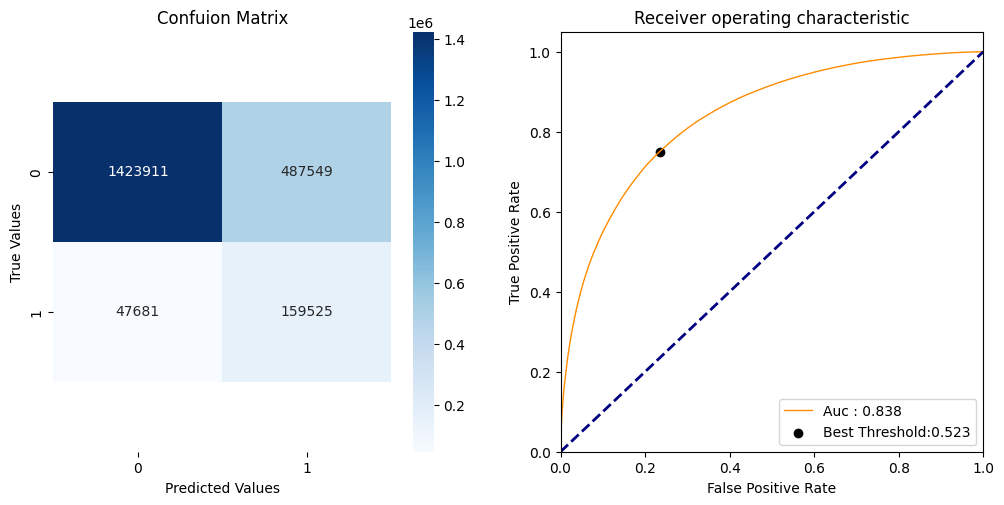

In [ ]:
print ("\n Classification report : \n",classification_report(y_test, predictions))
print ("Accuracy   Score : ",accuracy_score(y_test, predictions))

#Confusion Matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confuion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

#F1-Score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#ROC_AUC_Score
model_roc_auc = roc_auc_score(y_test,probability)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,probability)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

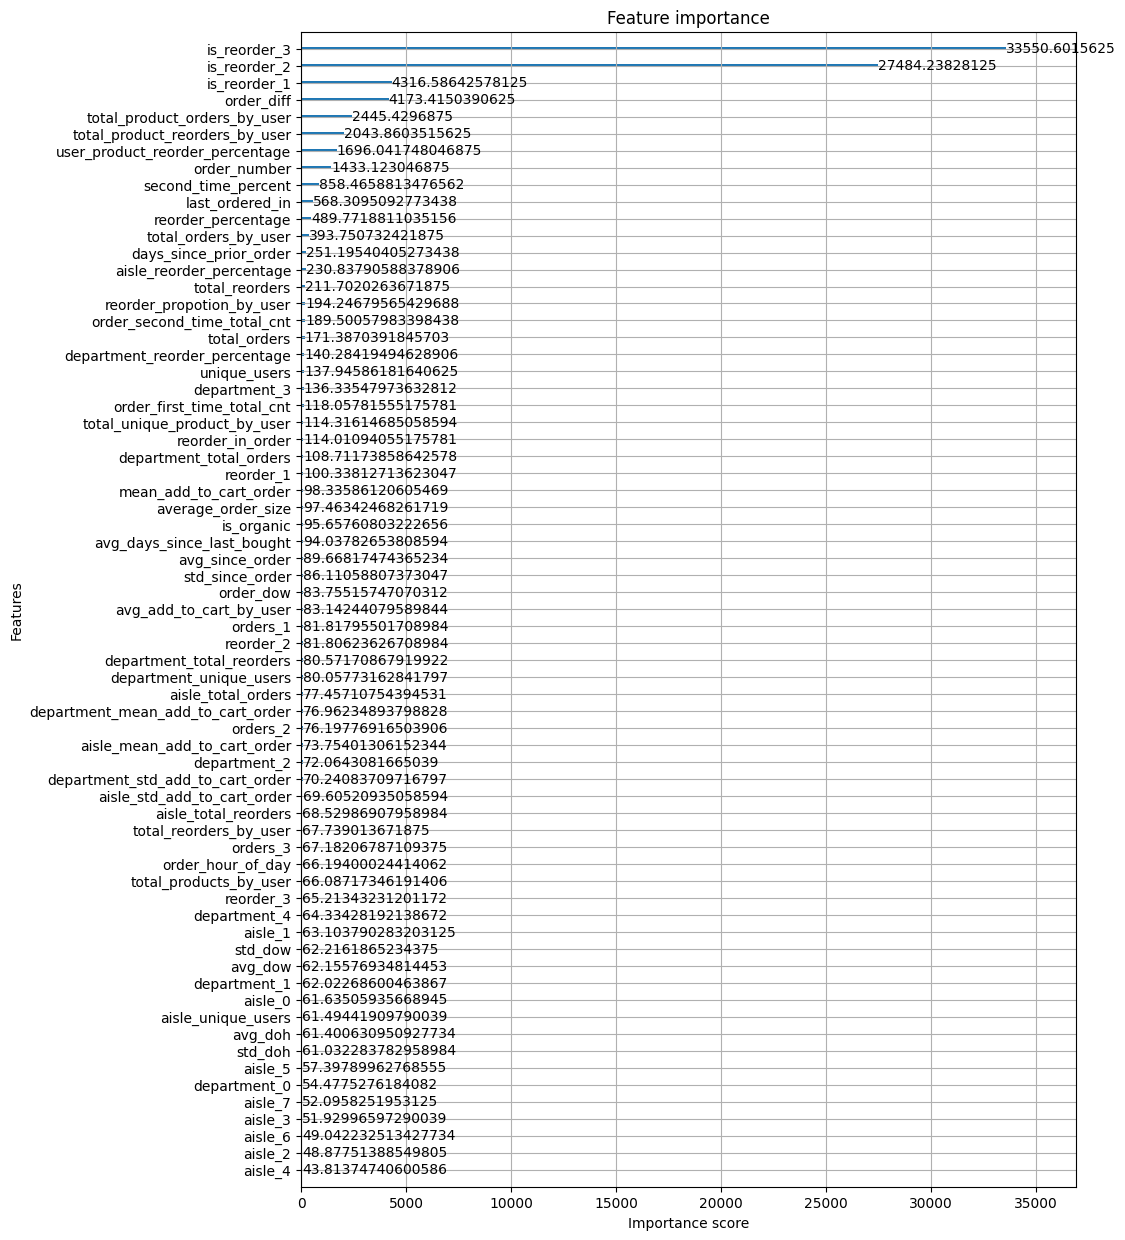

In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))
xgb.plot_importance(model, ax=ax, importance_type='gain')
